# Question 2

## Imports and Setups

In [7]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Install a conda package in the current Jupyter kernel
# !conda install --yes --prefix {sys.prefix} matplotlib
%matplotlib inline  

## Constants

In [9]:
# ==================== Constants ====================
OPENCV_ENABLE_NONFREE = True
IMAGE_DIR = "./q2_images/"
LEFT_IMAGE_NAME = "000020_left.jpg"
RIGHT_IMAGE_NAME = "000020_right.jpg"
OUT_DIR = "./out/q2/"
BOUNDING_BOX_FILE_NAME = "000020.txt"
ALL_CALIB_FILE_NAME = "000020_allcalib.txt"

### Parameters

In [33]:
# ==================== Parameters ====================
# bounding box defined in ./q2_images/000020.txt
with open(IMAGE_DIR + BOUNDING_BOX_FILE_NAME) as file:
    x_min, y_min, x_max, y_max = [float(i) for i in file.read().split()[1:]]
# parameters are defined in ./q2_images/000020_allcalib.txt
with open(IMAGE_DIR + ALL_CALIB_FILE_NAME) as file:
    f, px, py, baseline = [float(i) for i in file.read().split()[1::2]]
# corners: (x, y) coords
top_left_float = np.array([x_min, y_min])
top_left = top_left_float.astype(np.int)
bottom_right_float = np.array([x_max, y_max])
bottom_right = bottom_right_float.astype(np.int)
# box shape: (#row, #col)
box_shape = (bottom_right[1] - top_left[1], bottom_right[0] - top_left[0])
print(top_left_float.astype(np.int), bottom_right_float.astype(np.int), f, px, py, baseline)

[685 181] [804 258] 721.5377 609.5593 172.854 0.5327119288


### Read Images

In [34]:
# ==================== Images ====================
left_img = cv2.imread(IMAGE_DIR + LEFT_IMAGE_NAME, cv2.IMREAD_COLOR)
right_img = cv2.imread(IMAGE_DIR + RIGHT_IMAGE_NAME, cv2.IMREAD_COLOR)
left_gray_img = cv2.imread(IMAGE_DIR + LEFT_IMAGE_NAME, cv2.IMREAD_GRAYSCALE)
right_gray_img = cv2.imread(IMAGE_DIR + RIGHT_IMAGE_NAME, cv2.IMREAD_GRAYSCALE)
left_copy = np.copy(left_img)
left_rectangle_image = cv2.rectangle(left_copy, (top_left[0], top_left[1]), 
                                     (bottom_right[0], bottom_right[1]), (0, 255, 0), 2)

## Image Experiments

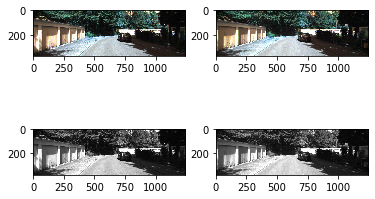

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].imshow(left_img)
axes[0, 1].imshow(right_img)
axes[1, 0].imshow(left_gray_img, cmap='gray')
axes[1, 1].imshow(right_gray_img, cmap='gray')
plt.show()

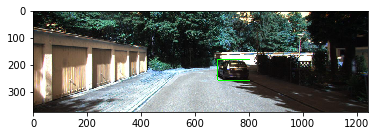

In [36]:
plt.imshow(left_rectangle_image)
plt.show()

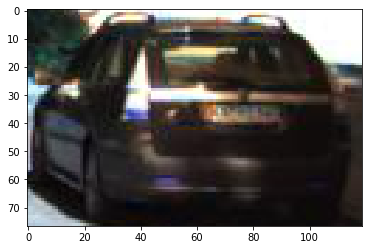

In [37]:
plt.imshow(left_img[top_left[1]: bottom_right[1], top_left[0]: bottom_right[0]])

In [39]:
left_img.shape # row, col, channel
box_shape

(77, 119)

## Helpers

In [19]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

## Part a

### Cost Functions

In [40]:
def SSD(l_patch: np.ndarray, r_patch: np.ndarray) -> float:
    """
    The Sum Squared Difference between the left patch and the right patch
    Note: When using SSD, look for minima

    :param l_patch: the left patch
    :param r_patch: the right patch
    :return: the sum squared difference
    """
    assert l_patch.shape == r_patch.shape, \
        f"The left shape {l_patch.shape} and right shape {r_patch.shape} are " \
        f"not equal"
    return float(np.sum(np.square(l_patch - r_patch), axis=None))

In [41]:
def NC(l_patch: np.ndarray, r_patch: np.ndarray) -> float:
    """
    The Normalized Coefficient between the left patch and the right patch
    Note: When using NC, look for maxima

    :param l_patch: the left patch
    :param r_patch: the right patch
    :return: the normalized coefficient
    """
    assert l_patch.shape == r_patch.shape, \
        f"The left shape {l_patch.shape} and right shape {r_patch.shape} are " \
        f"not equal"
    norm_prod = np.linalg.norm(l_patch) * np.linalg.norm(r_patch)
    if norm_prod == 0:
        return 0
    return float(np.sum(l_patch * r_patch) / norm_prod)

### Part a function

In [62]:
def part_a(l_img: np.ndarray, r_img: np.ndarray, block_size: int = 3, step: int = 1) -> None:
    """
    Compute the depth for each pixel in the given bounding box of car.

    Algorithm:
        - Given a left patch, compare it with all the patches on the right
          image’s scanline.
        - To reduce computation complexity, we use a small patch size, or sample
          patches (e.g. every other pixel) from scanline instead of comparing
          with all possible patches.

    Report:
        - patch size, sampling method, and matching cost function.
        - how depth is computed for each pixel.
        - visualize the depth information. report outliers from incorrect
          point correspondences?
    """
    print("{0} Part A Start {0}".format("=" * 20))
    
    assert len(l_img.shape) == len(r_img.shape), "Images have different channels"
    
    if len(l_img.shape) == 2:
        l_img = l_img[:, :, np.newaxis]
        r_img = r_img[:, :, np.newaxis]

    half_block_size = block_size // 2

    SSD_mask = np.zeros(r_img.shape[:2])
    SSD_depth = np.zeros(box_shape)
    NC_mask = np.zeros(r_img.shape[:2])
    NC_depth = np.zeros(box_shape)

    # for each pixel in the bounding box in the left image, find the
    # corresponding pixel in the right image along the scanline
    for x in range(top_left[1], bottom_right[1]):
        print(f"Processing row {x} / {bottom_right[1]}")
        for ly in range(top_left[0], bottom_right[0]):
            l_patch = l_img[
                      x - half_block_size: x + half_block_size + 1,
                      ly - half_block_size: ly + half_block_size + 1, :]

            # keep track of all computed cost/correlations along the scanline
            SSDs = np.full((r_img.shape[1],), np.inf)
            NCs = np.full((r_img.shape[1],), -np.inf)

            # only loop where r_patch's shape will match with that of l_patch
            for ry in range(half_block_size,
                            min(ly, r_img.shape[1] - half_block_size),
                            step):
                r_patch = r_img[
                          x - half_block_size: x + half_block_size + 1,
                          ry - half_block_size: ry + half_block_size + 1, :]
                SSDs[ry] = SSD(l_patch, r_patch)
                NCs[ry] = NC(l_patch, r_patch)

            min_SSD, SSD_ry = np.min(SSDs), np.argmin(SSDs)
            max_NC, NC_ry = np.max(NCs), np.argmax(NCs)

            # Mark the corresponding location for debugging
            # print((x, SSD_ry), (x, NC_ry))
            SSD_mask[x, SSD_ry] = 255
            NC_mask[x, NC_ry] = 255

            # calculate depth and map to depth matrix
            depth_x, depth_y = x - top_left[1], ly - top_left[0]
            if ly - SSD_ry == 0:
                SSD_depth[depth_x, depth_y] = 0
            else:
                SSD_depth[depth_x, depth_y] = f * baseline / (
                        ly - SSD_ry)
            if ly - NC_ry == 0:
                NC_depth[depth_x, depth_y] = 0
            else:
                NC_depth[depth_x, depth_y] = f * baseline / (
                        ly - NC_ry)
    print("{0} Part A End {0}".format("=" * 20))
    return SSD_mask, NC_mask, SSD_depth, NC_depth

In [58]:
SSD_mask, NC_mask, SSD_depth, NC_depth = part_a(left_gray_img, right_gray_img, 3, 1)

==================== Part A Start ====================
Processing row 181 / 258
Processing row 182 / 258
Processing row 183 / 258
Processing row 184 / 258
Processing row 185 / 258
Processing row 186 / 258
Processing row 187 / 258
Processing row 188 / 258
Processing row 189 / 258
Processing row 190 / 258
Processing row 191 / 258
Processing row 192 / 258
Processing row 193 / 258
Processing row 194 / 258
Processing row 195 / 258
Processing row 196 / 258
Processing row 197 / 258
Processing row 198 / 258
Processing row 199 / 258
Processing row 200 / 258
Processing row 201 / 258
Processing row 202 / 258
Processing row 203 / 258
Processing row 204 / 258
Processing row 205 / 258
Processing row 206 / 258
Processing row 207 / 258
Processing row 208 / 258
Processing row 209 / 258
Processing row 210 / 258
Processing row 211 / 258
Processing row 212 / 258
Processing row 213 / 258
Processing row 214 / 258
Processing row 215 / 258
Processing row 216 / 258
Processing row 217 / 258
Processing row 218 /

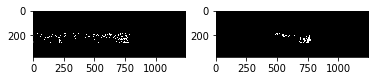

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(SSD_mask, cmap=plt.cm.gray)
axes[1].imshow(NC_mask, cmap=plt.cm.gray)
plt.show()

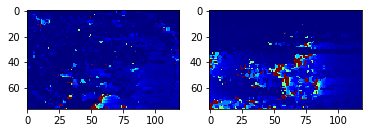

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(SSD_depth, cmap=plt.cm.jet)
axes[1].imshow(NC_depth, cmap=plt.cm.jet)
plt.show()

In [70]:
# Convert depth maps to appropriate scale
SSD_depth_adjusted = np.copy(SSD_depth)
NC_depth_adjusted = np.copy(NC_depth)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(SSD_depth_adjusted.flatten())
print(min_val, max_val, min_loc, max_loc)
print(max_val * 255. / float(max_val - min_val + 1))
SSD_depth_adjusted -= min_val
SSD_depth_adjusted = cv2.convertScaleAbs(SSD_depth_adjusted, None,
                                     255. / float(max_val - min_val + 1))
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(NC_depth_adjusted.flatten())
NC_depth_adjusted -= min_val
NC_depth_adjusted = cv2.convertScaleAbs(NC_depth_adjusted, None,
                                    255. / float(max_val - min_val + 1))

0.4822731993336458 384.3717398689157 (0, 9161) (0, 644)
254.65699156354606


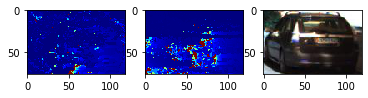

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].imshow(SSD_depth_adjusted, cmap=plt.cm.jet)
axes[1].imshow(NC_depth_adjusted, cmap=plt.cm.jet)
axes[2].imshow(left_img[top_left[1]: bottom_right[1], top_left[0]: bottom_right[0]], cmap=plt.cm.jet)
plt.show()

In [ ]:
cv2.imwrite(OUT_DIR + f"a_{block_size}_{step}_SSD_mask.jpg", SSD_mask)
cv2.imwrite(OUT_DIR + f"a_{block_size}_{step}_NC_mask.jpg", NC_mask)
cv2.imwrite(OUT_DIR + f"a_{block_size}_{step}_SSD_depth.jpg", SSD_depth)
cv2.imwrite(OUT_DIR + f"a_{block_size}_{step}_NC_depth.jpg", NC_depth)
cv2.imwrite(OUT_DIR + f"a_{block_size}_{step}_SSD_depth.jpg",
            SSD_depth)
cv2.imwrite(OUT_DIR + f"a_{block_size}_{step}_NC_depth.jpg",
            NC_depth)

In [ ]:
def stitch_images():
    block_sizes = [1, 3, 5]
    patch_sizes = [1, 3, 5]
    plt.clf()
    fig, axes = plt.subplots(nrows=9, ncols=2)
    for i in range(len(block_sizes)):
        for j in range(len(patch_sizes)):
            block_size = block_sizes[i]
            patch_size = patch_sizes[j]
            curr_img = cv2.imread(
                OUT_DIR + f"a_{block_size}_{patch_size}_SSD_depth.jpg")
            axes[3 * i + j][0].imshow(curr_img, cmap='gray')
            axes[3 * i + j][0].axis('off')
            curr_img = cv2.imread(
                OUT_DIR + f"a_{block_size}_{patch_size}_NC_depth.jpg")
            axes[3 * i + j][1].imshow(curr_img, cmap='gray')
            axes[3 * i + j][1].axis('off')

    plt.savefig(OUT_DIR + "a_all.jpg")

In [ ]:
block_sizes = [1, 3, 5]
patch_sizes = [1, 3, 5]

for block_size in [1, 3, 5]:
    for step in [1, 3, 5]:
        part_a(block_size, step, save_image=True)
stitch_images()